# Evaluation and visualization of structural differences in blood vessels between samples using sliced Wasserstein kernel

This tutorial provides instructions for how to
evaluate structural differences in blood vessels between samples using sliced Wasserstein kernel. The sliced Wasserstein kernel is available from the R package [kernelTDA](https://github.com/tulliapadellini/kernelTDA) which provides an R implementation of the most popular kernels to be used in the space of persistence diagrams.

## Download persistence diagram files

This tutorial uses persistence diagram files as lymphatic vessels in the lung fibrosis model which was described in Figure 6 of Takahashi et al. (2022).
**Note**: See this notebook for a tutorial on how to compute the persistence diagrams from 3D CUBIC signal data.

In [ ]:
T1 <- Sys.time()
system("wget https://www.dropbox.com/s/huwdqodsbk2ulny/tutorial_swk_data.zip")
system("unzip /content/tutorial_swk_data.zip")
T2 <- Sys.time()
T2 - T1

Time difference of 1.481291 secs

## Install R packages

Install the R packages including kernelTDA for computing sliced Wasserstein kernel and load the packages

In [ ]:
T1 <- Sys.time()
install.packages("remotes")
remotes::install_github("tulliapadellini/kernelTDA")
install.packages("data.table")
install.packages("ggrepel")
library(kernelTDA)
library(data.table)
library(Matrix)
library(tidyverse)
library(ggrepel)
T2 <- Sys.time()
T2 - T1

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Skipping install of 'kernelTDA' from a github remote, the SHA1 (1897995b) has not changed since last install.
  Use `force = TRUE` to force installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Time difference of 29.31197 secs

Read the R package "readr" for reading csv data

## Reading the persistence diagram files

List the files in the directory and select the downloaded files.

In [ ]:
T1 <- Sys.time()
pd1_files <- list.files("/content/tutorial_swk_data",full.names=TRUE,pattern="pd1\\.txt$")
pd2_files <- list.files("/content/tutorial_swk_data",full.names=TRUE,pattern="pd2\\.txt$")
T2 <- Sys.time()
T2 - T1

Time difference of 0.004181623 secs

## Calculation of sliced Wasserstein kernel between each pair of persistance diagrams using the R function sw.kernel

Compute the sliced Wasserstein kernel between each pair of persistence diagrams.


In [ ]:
filenames <- gsub("-pd1\\.txt","",basename(pd1_files))

K1 <- matrix(0,length(pd1_files),length(pd1_files))
for(i in 1:length(pd1_files)){
  x1 <- as.matrix(fread(pd1_files[i],header=FALSE,sep=" "))
  x2 <- as.matrix(fread(pd2_files[i],header=FALSE,sep=" "))
  x <- rbind(cbind(1,x1),cbind(2,x2))
  for(j in 1:length(pd1_files)){
    if(i < j){
      y1 <- as.matrix(fread(pd1_files[j],header=FALSE,sep=" "))
      y2 <- as.matrix(fread(pd2_files[j],header=FALSE,sep=" "))
      y <- rbind(cbind(1,y1),cbind(2,y2))
      K1[i,j] <- sw.kernel(x,y,h=1,dimension=1)
    }
  }
}
K1 <- t(K1) + K1
diag(K1) <- 1

Plot the kernel matrix between the 8 samples where the first 6 samples represent the blyeomycin treated group and the last 3 samples represent the control group.

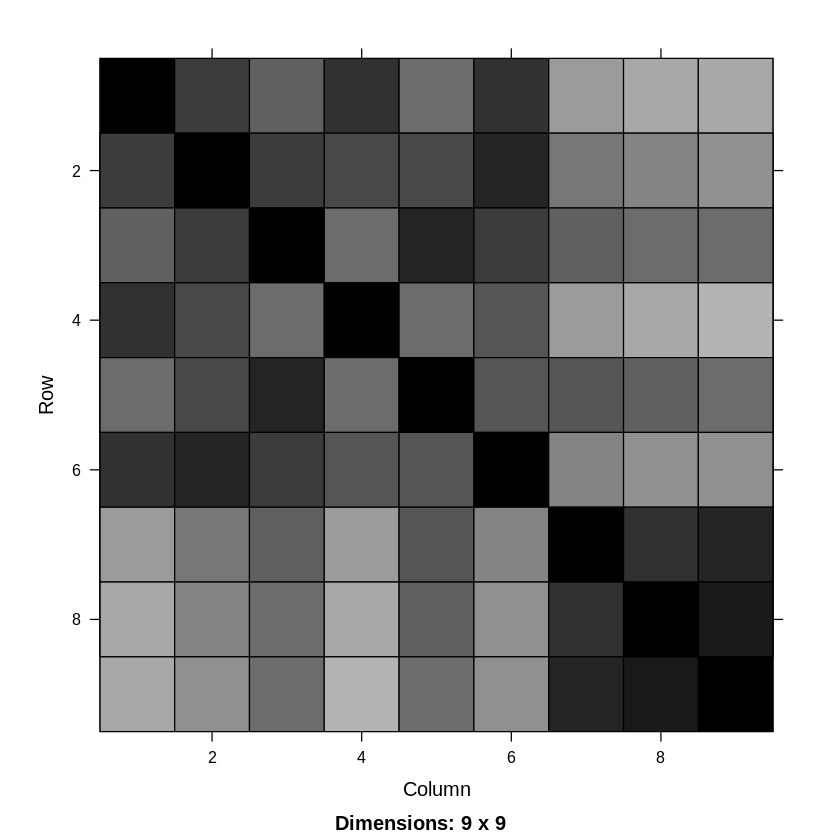

In [ ]:
image(Matrix(K1))

## Multi-dimensional scaling (MDS) for visualization of the relative positions of the vessel objects from the distance matrix
Using as an input the distance matrix defined by 1 minus the kernel matrix, perform a multidimensional scaling method (MDS) that maps the information of geometric distances between samples to an abstract orthogonal space using the Sliced Wasserstein kernel.

In [ ]:
obj <- cmdscale(dist(1-K1))

Display the relative positions of the vessel objects from the distances.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Too few points to calculate an ellipse



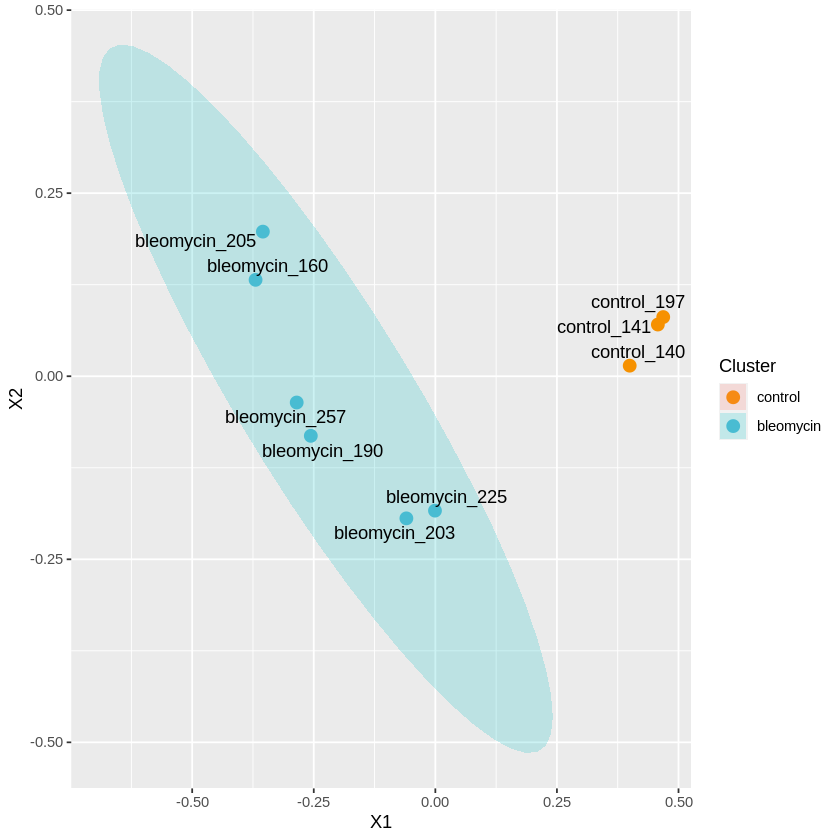

In [ ]:
condition <- sapply(strsplit(filenames,"_"),function(x){x[1]})
df <- data.frame(X1=obj[,1],X2=obj[,2],label=filenames,
  cluster=factor(condition,levels=c("control","bleomycin")))
color <- c("#F69100","#5BBCD6","#FF0000","#50A45C")
ggplot(df, aes(x = X1, y = X2, label = label)) +
  geom_point(aes(x=X1, y=X2, color=factor(cluster)), size=5, shape=20) +
  stat_ellipse(aes(x=X1,y=X2,fill=factor(cluster)),
               geom="polygon", level=0.95, alpha=0.2) +
               scale_color_manual(values = color) +
  geom_text_repel() + 
  guides(color=guide_legend("Cluster"),fill=guide_legend("Cluster")) +
  theme(plot.title = element_text(hjust = 0.5))
